# 简单线性迭代聚类

本节讨论生成超像素的一种算法，即简单线性迭代聚类(SLIC)。与其他超像素技术相比具有计算优势和其他性能优势。SILC是对k-means算法的一种改进。SLIC观测通常使用（但不限于）包含三个颜色分量和两个空间坐标的五维向量。例如正在使用RGB彩色系统，那么与图像像素相关的五维向量为：
$$
    z = \begin{bmatrix} r \\ g \\b \\ x\\ y \end{bmatrix}
$$

式中。（r,g,b）是像素的三个颜色的分量，（x，y）是像素的两个空间坐标。令
$n_{sp}$是所需要的超像素个数，$n_{tp}$是图像中的像素总数。初始的超像素中心$m_i = [r_i,g_i,b_i,x_i,y_i]^T$, $i = 1 ,2,...,n_{sp}$是对图像以间距s个单位的规则网格取样得到的。为了生成大小近似相等的超像素，选择网格间距 $s = [n_{tp} / n_{sp}] ^ {1/2}$。为了防止在图像边缘对超像素的中心化，并减少从噪声点开始的机会，将初始聚类中心移到每个中心周围的 $ 3 \times 3 $领域的最小梯度位置。

## SLIC算法由以下步骤组成

1. 初始化算法：以规则网格步长 $s$对图像采样，计算初始的超像素聚类中心
$$
    m_i = [r_i , g_i,b_i,x_i,y_i]^T,i=1,2,3...n_{sp}
$$
将聚类中型移动至 $3 \times 3$领域中最小梯度位置。对于像素中的每个像素位置p ， 设置标签 $L(p) = -1$ 和距离 $d(p) = \infty$

2. 将样本分配给聚类中心：对，每个聚类中心$m_i , i = 1,2,...,n_{sp}$ ,在一个关于$ m_i $的 $ 2s \times 2s $领域中，计算 $ m_i $与每个像素 $p$之间的距离$D_i(p)$。然后，对每个$p$和$i = 1, 2 , ...,n_{sp}$,诺$D_i < d(p) $,则令$d(p) = D_i$和 $L(p) = i$

3. 更新聚类中心：令$C_i$表示图像中具有标记$L(p)=i$的像素集。更新$m_i$:
$$
    m_i = \frac{1}{|C_i|} \sum_{z \in C_i}z , i = 1,2,...,n_{sp}
$$

4. 收敛性检验：计算当前步骤和前述步骤中平均向量之间的差的欧几里德范数。计算残差E，即$n_{sp}$个范数值和。诺$E<T$,其中T是一个规定的非负阈值。则进入步骤5，否则进入步骤2

5. 后处理像素区域：将每个区域$C_i$中的所有超像素替换为他们的平均值$m_i$。

## 规定距离测度

SLIC超像素对应一个空间中的聚类，这个空间的坐标是颜色和空间变量。 在这种情况下，使用单个欧式距离是没有意义的，因为这个坐标系的轴的尺度是不同的，并且是不相关的。换句话说，空间距离和颜色距离必须分开处理。这是通过首先归一化各个分量的距离，然后将他们组合为单个测度来实现的。令$d_c$和$d_s$分别是聚类中的两个点间的颜色距离和空间欧氏距离：
$$
    d_c = [(r_j - r_i) ^ 2 + (g_j - g_i) ^ 2 + (b_j - b_i) ^ 2]^ {1/2}
$$
和 
$$
    d_s = [(x_j - x_i) ^ 2 + (y_j - y_x) ^ 2] ^ {1/2}
$$
然后将D定义为复合距离
$$
    D = [(d_c / d_{cm})^2 + (d_s / d_{sm}) ^2] ^{1/2}
$$

式中$d_{cm}$和$d_{sm}$是$d_c$和$d_s$的最大期望值。最大空间距离应对于取样间隔，即$d_{sm} = s = [n_{tp} / n_{sp}] ^ {1/2}$。求最大颜色距离并不简单。因为这些距离可能会因聚类的不同而不同，也可能会因图像的不同而不同用。一种解法是，将$d_{cm}$设置为一个常数c ， 使得
$$
    D = [(d_c / c) ^ 2 + (d_s / s) ^ 2 ]^{1/2}
$$
我们可将上式写为
$$
    D = [(d_c) ^ 2 + (d_s / s) ^ 2 c^2]^{1/2}
$$
这是对算法中的每个聚类使用的距离测度。常数c可用来加权颜色相似性和空间接近性的相对重要性。当c很大时，空间接近性更重要，由此产生的超像素更紧凑。当c较小时，产生的超像素对图像边界有着更强的附着性，但大小和形状更不规则。

对于灰度级图像
$$
    d_c = [(l_j - l_i) ^ 2] ^{1/2}
$$

In [102]:
import numpy as np 
import matplotlib.pyplot as plt 
import math


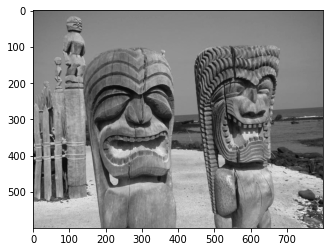

In [103]:
f = plt.imread("./../images/totem-poles.tif")
plt.imshow(f, "gray")

In [104]:

def get_gradient(f , y , x ):
    return (f[y + 1][x]  - f[y - 1][x] + f[y][x + 1] -f [y][x- 1]) /  2 
def init_cluster(f,k):
    cluster = []
    h , w = f.shape         
    s = int(math.sqrt(h * w / k)) 
    y = s 
    while y < h :
        x = s 
        while x < w:
            l = f[y][x]
            cluster.append([y,x ,l])
            x = x + s  
        y = y + s     
    # 对比cluster周围3领域的梯度， 将聚类中心移动到最小梯度的位置上
    for ci in range(len(cluster)):
        clu = cluster[ci]
        y = clu[0]
        x = clu[1]
        gradient = get_gradient(f, y , x)
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                next_y = y+dy 
                next_x = x + dx
                _gradient = get_gradient(f, next_y , next_x)
                if gradient > _gradient : 
                    gradient = _gradient 
                    clu[0] == next_y 
                    clu[1] = next_x
                    clu[2] = f[next_y][next_x]
    return np.array(cluster) , s


"""
规定距离测度
"""
def nomalize_distance(cluster ,  super_pixel , dsm , c  = 1):   
    y,x,l = cluster 
    _y,_x ,_l = super_pixel 
    dc = abs(l - _l)

    ds = ( y - _y ) ** 2 + (x  - _x) ** 2   
    return dc ** 2 + ds  / (dsm ** 2) * c ** 2

"""
f 元图像
k 聚类个数
T 迭代停止阈值
"""
def slic(f,k,cluster = None , T = 0.001 , s = None):
    h,w = f.shape
    _f = np.zeros((h,w,2) , dtype="float")
    _f[:,:,0] = -1 
    _f[:,:,1] = float('inf')    
    ori_cluster = None 
    # 初始化聚类中心
    if cluster is None : 
        cluster , s = init_cluster(f, k)
    _cluster = np.zeros(len(cluster)) + 1
    ori_cluster = cluster.copy()
    for y in range(h):
        for x in range(w):
            value = f[y][x]
            min_dist = None 
            closest_cluster_index = None 
            superpixel = [y,x,value]
            for ci in range(len(cluster)):
                if min_dist is None : 
                    dist = nomalize_distance(cluster[ci] , superpixel ,  dsm = s)
                    min_dist = dist 
                    closest_cluster_index = ci 
                else : 
                    dist = nomalize_distance(cluster[ci] , superpixel ,  dsm = s) 
                    if min_dist > dist : 
                        dist = min_dist
                        closest_cluster_index = ci
            # Update
            _f[y][x] = np.array([closest_cluster_index , min_dist])
            count = _cluster[closest_cluster_index] 
            mean = (count * cluster[closest_cluster_index] + superpixel) / (count + 1 )
            cluster[closest_cluster_index] = mean
            _cluster[closest_cluster_index] = _cluster[closest_cluster_index] + 1

    # 完成一次聚类，检测阈值
    E = np.linalg.norm(
        np.array(
        [np.mean(ori_cluster[:,:1]), 
        np.mean(ori_cluster[:,1:2]),
        np.mean(ori_cluster[:,2:])
        ]) - 
        np.array([
        np.mean(cluster[:,:1]), 
        np.mean(cluster[:,1:2]),
        np.mean(cluster[:,2:3])
        ])
    )
    print ("E" , E)
    
    if E > T :
        return slic(f,k,cluster = cluster,T = T , s = s)
    else:
        return cluster , _f 

In [105]:
cluster , g_label = slic(f , 250 , T = 1 )

<ipython-input-104-2c5390fceafd>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  return (f[y + 1][x]  - f[y - 1][x] + f[y][x + 1] -f [y][x- 1]) /  2
E 41.01532121807606


KeyboardInterrupt: 

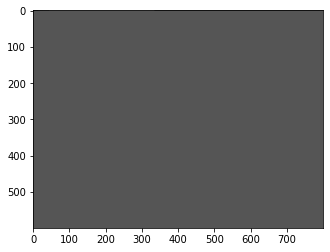

In [101]:
g = np.zeros(f.shape)
h,w = f.shape
for y in range(h):
    for x in range(w) : 
        label , d = g_label[y][x]
        _,_,l= cluster[int(label)]
        g[y][x] = l

plt.imshow(g ,"gray")